In [2]:
%matplotlib inline

import numpy as np # grey images are stored in memory as 2D arrays, color images as 3D arrays
import cv2 as cv2 # opencv computer vision library
from skimage import io # for io.imread
from matplotlib import pyplot as plt # ploting
from matplotlib import colors # ploting

# interactive notebook widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual


### imshow

In [6]:

def imshow(images, titles, nrows = 0, ncols=0, figsize = (15,20)):
    """Plot a multiple images with titles.

    Parameters
    ----------
    images : image list
    titles : title list
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    if ncols == 0 and nrows == 0:
      ncols = len(images)
      nrows = 1
    if ncols == 0:
      ncols = len(images) // nrows
    if nrows == 0:
      nrows = len(images) // ncols
      
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, squeeze=False, figsize = figsize)
    for i, image in enumerate(images):
        axeslist.ravel()[i].imshow(image, cmap=plt.gray(), vmin=0, vmax=255)
        axeslist.ravel()[i].set_title(titles[i])
        axeslist.ravel()[i].set_axis_off()
    plt.tight_layout() # optional
    fig.show()


/tmp/ipykernel_81937/3082500363.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


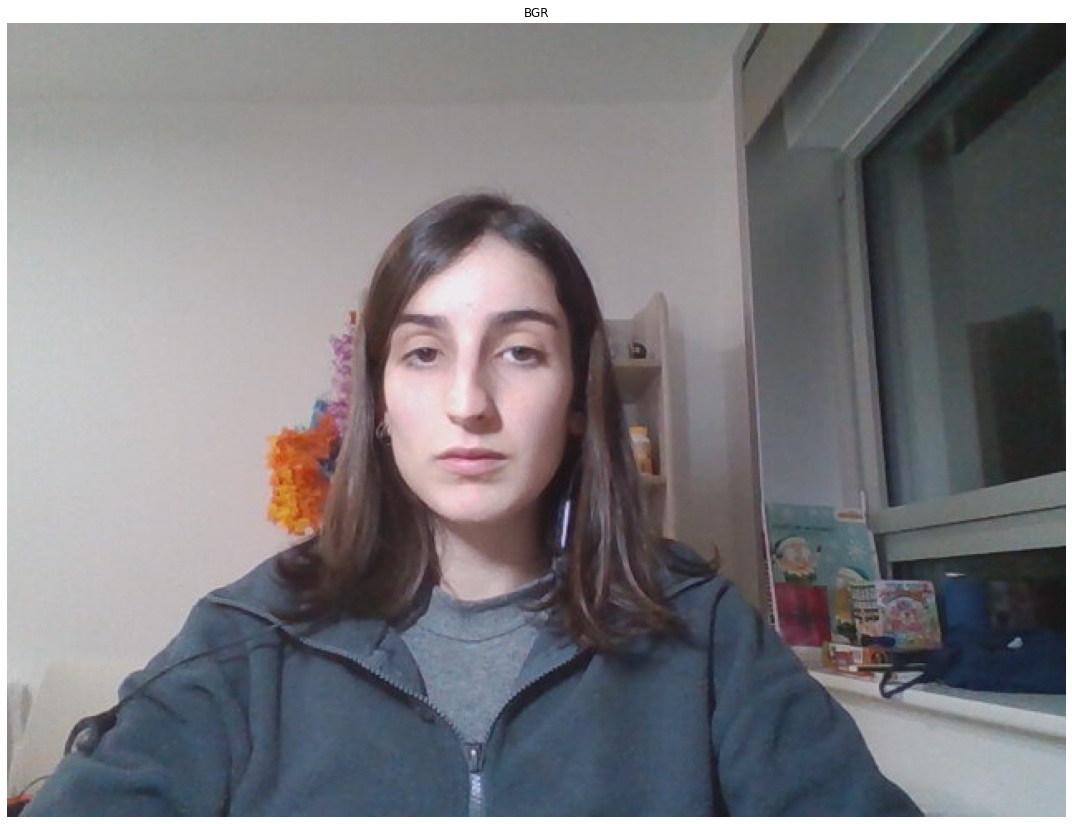

In [12]:
url = '/home/laura/Pictures/Webcam/2021-12-12-233803.jpg'
imageBGR = io.imread( url ) 
imageGray = cv2.cvtColor(imageBGR, cv2.COLOR_BGR2GRAY)
gx_sobel_cv = cv2.Sobel(imageGray,cv2.CV_64F,1,0,3)/8
gy_sobel_cv = cv2.Sobel(imageGray,cv2.CV_64F,0,1,3)/8
imshow([imageBGR], ['BGR'])

In [14]:
imageGray

array([[160, 162, 163, ...,  32,  33,  34],
       [161, 161, 162, ...,  32,  32,  33],
       [162, 161, 160, ...,  30,  32,  32],
       ...,
       [ 49,  48,  47, ..., 183, 182, 182],
       [ 48,  48,  47, ..., 183, 183, 183],
       [ 47,  47,  48, ..., 184, 184, 185]], dtype=uint8)

### Calculating the gradients

/tmp/ipykernel_81937/3082500363.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


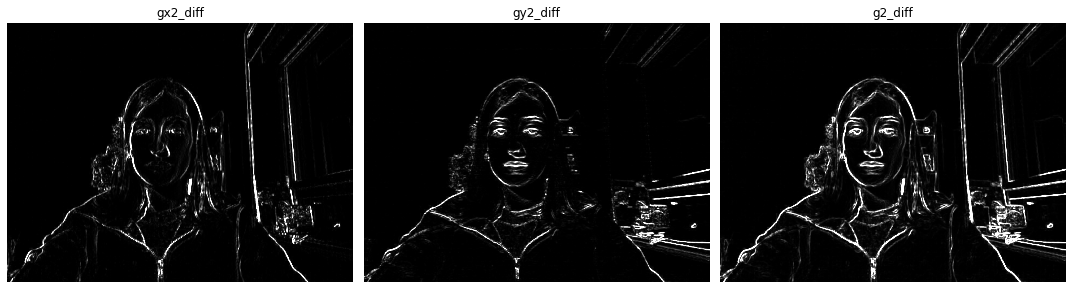

In [15]:
def gradient_y_diff(img):
  img = img.astype(float)
  # 1:-1 for the rows, since we want to return values
  # where convolution filter is entirely enclosed in OG img
  return img[1:-1, 1:-1]-img[0:-2, 1:-1]

def gradient_x_diff(img):
  img = img.astype(float)
  # 1:-1 for the rows, since we want to return values
  # where convolution filter is entirely enclosed in OG img
  return img[1:-1,1:-1]-img[1:-1, 0:-2]

gx_diff = gradient_x_diff(imageGray)/2
gy_diff = gradient_y_diff(imageGray)/2
gx2_diff = gx_diff ** 2
gy2_diff = gy_diff ** 2
g2_diff = gx2_diff + gy2_diff
imshow([gx2_diff, gy2_diff, g2_diff], ['gx2_diff', 'gy2_diff', 'g2_diff'])


/tmp/ipykernel_81937/3082500363.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


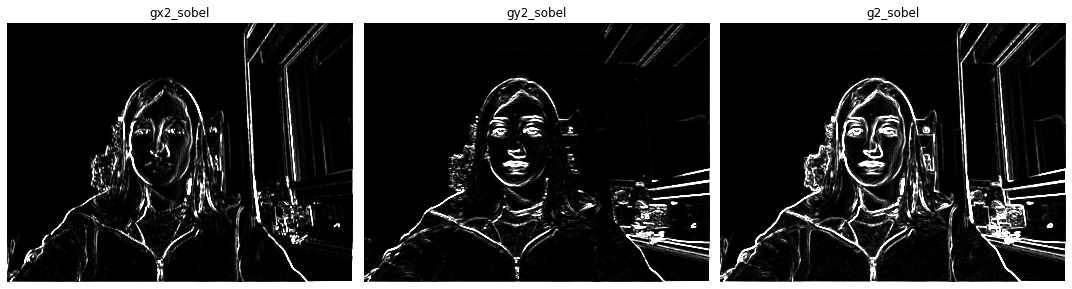

In [16]:
def gradient_y_sobel(img):
  img = img.astype(float)
  img_new = img.copy()

  # Only using Sobel Operator on interior points 
  for i in range(1, img.shape[0]-2) :
    for j in range(1, img.shape[1]-2) :
      img_new[i, j] = np.sum(img[i-1:i+2, j-1:j+2]*np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]))

  return  img_new[1:-1, 1:-1]

def gradient_x_sobel(img):
  img = img.astype(float)
  img_new = img.copy()

  # Only using Sobel Operator on interior points 
  for i in range(1, img.shape[0]-2) :
    for j in range(1, img.shape[1]-2) :
      img_new[i, j] = np.sum(img[i-1:i+2, j-1:j+2]*np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]))
  
  return img_new[1:-1, 1:-1]

gx_sobel = gradient_x_sobel(imageGray)/8
gy_sobel = gradient_y_sobel(imageGray)/8
gx2_sobel = gx_sobel ** 2
gy2_sobel = gy_sobel ** 2
g2_sobel = gx2_sobel + gy2_sobel
imshow([gx2_sobel, gy2_sobel, g2_sobel], ['gx2_sobel', 'gy2_sobel', 'g2_sobel'])

/tmp/ipykernel_81937/3082500363.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


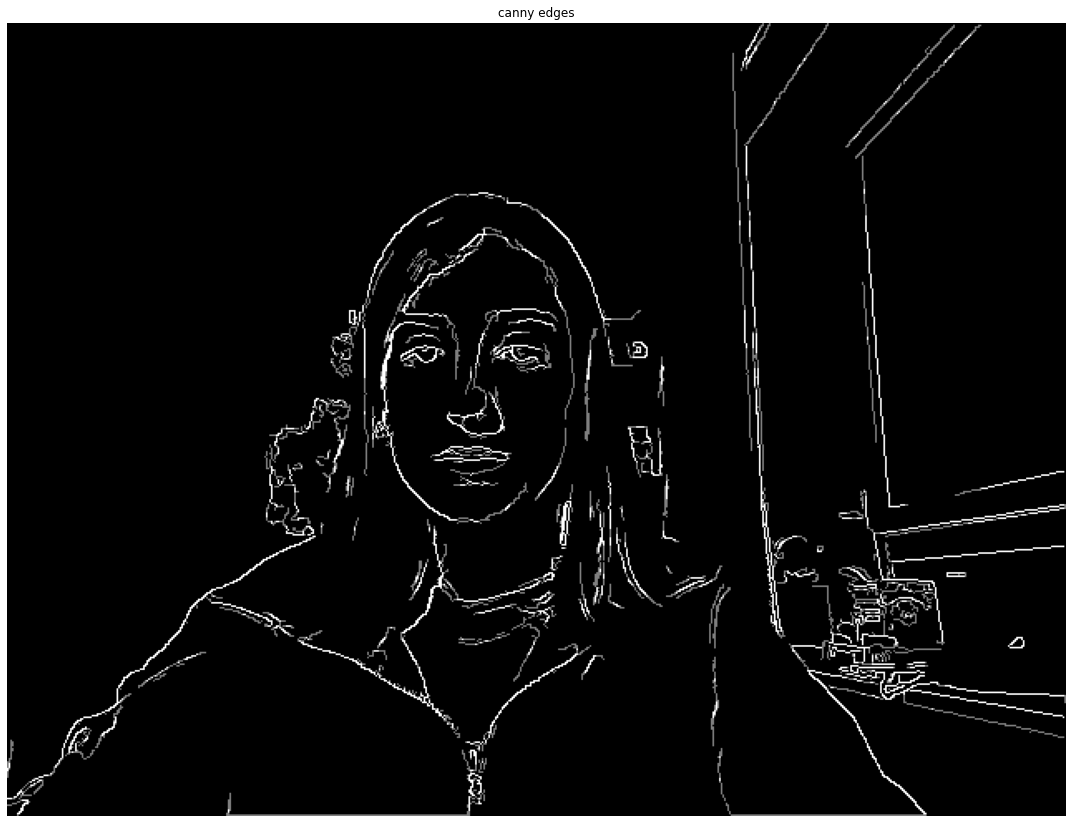

In [19]:
from collections import deque

def canny(gx, gy, low = None, high = None):
  
  mag, ang = cv2.cartToPolar(gx, gy, angleInDegrees = True) 
  
  if not high: high = 0.5 * mag.max() # just a guess, for what it is worth, 50% max
  if not low: low = 0.1 * mag.max() # just a guess, for what it is worth, 10% max

  height, width = mag.shape 
      
  queue = deque()
  edges = np.zeros_like(mag)

  for i_x in range(width-1): 
      for i_y in range(height-1): 
              
          grad_ang = ang[i_y, i_x] 
          
          # tests to compute the neighbor coordinates in the direction of the gradient grad_ang (Non-local maximum supression)
          condlist = [((grad_ang >= -22.5) & (grad_ang < 22.5)) | ((grad_ang >= 157.5) & (grad_ang < 202.5)), # horizontal
                      ((grad_ang >= 22.5) & (grad_ang < 67.5)) | ((grad_ang >= 202.5) & (grad_ang < 247.5)), # diagonal
                      ((grad_ang >= 67.5) & (grad_ang < 112.5)) | ((grad_ang >= 247.5) & (grad_ang < 292.5)), # vertical 
                      ((grad_ang >= 112.5) & (grad_ang < 157.5)) | ((grad_ang >= 292.5) & (grad_ang < 337.5))] # other diagonal
          choicelist_1 = [mag[i_y, i_x-1], mag[i_y+1, i_x-1], mag[i_y+1, i_x], mag[i_y-1, i_x-1]]
          choicelist_2 = [mag[i_y, i_x+1], mag[i_y-1, i_x+1], mag[i_y-1, i_x], mag[i_y+1, i_x+1]]
          neighb_1_mag = np.select(condlist, choicelist_1)
          neighb_2_mag = np.select(condlist, choicelist_2)

          # If not a local maximum, set magnitude to 0
          if ~((mag[i_y, i_x] > neighb_1_mag) & (mag[i_y, i_x] > neighb_2_mag)) : mag[i_y, i_x] = 0 

          
          # look the magnitude of the gradients at the 2 neigbors and discard i_y,i_x if its magnitude is inferior
          if mag[i_y, i_x] >= high:
            queue.append((i_y, i_x)) # Storing the position of the strong edges
            edges[i_y, i_x] = 255

  while queue:
    p = queue.popleft()
    for i in range(-1, 2, 1):
      for j in range(-1, 2, 1):
        i_y = p[0]+j
        i_x = p[1]+i
        # Making sure these coordinates are in the range of mag
        # If not, ignore and move on
        if((i_y < height) & (i_y >= 0) & (i_x < width) & (i_x >= 0)) :
          if (mag[i_y, i_x] >= low) & (mag[i_y, i_x] < high):
              queue.append((i_y, i_x))
              edges[i_y, i_x] = 127
              # Change magnitude of newly added edge so that we do not re-add it 
              mag[i_y, i_x] = 0

  return edges
  
imshow([canny(gx_sobel, gy_sobel, 10, 20)], ['canny edges'])